In [1]:
import pandas as pd
import numpy as np
import os


def createXY(dataset: pd.DataFrame, n_past: int, column_target: str):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset)):
        dataX.append(dataset.iloc[i - n_past:i].values)
        dataY.append(dataset[column_target].values[i])
    # Convert lists to numpy arrays for uniformity
    return np.array(dataX), np.array(dataY)

def process_files(columns_all, column_target, folder_path, n_past=1):
    all_dataX, all_dataY = np.array([]), np.array([])
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            series = pd.read_csv(file_path)
            single_dataset = series[columns_all]
            dataX, dataY = createXY(single_dataset, n_past, column_target[0])
            # Concatenate the new arrays with the existing ones
            all_dataX = np.vstack([all_dataX, dataX]) if all_dataX.size else dataX
            all_dataY = np.concatenate([all_dataY, dataY]) if all_dataY.size else dataY
    return all_dataX, all_dataY

columns_all = ['CGM (mg / dl)', 'CSII - basal insulin (Novolin R, IU / H)']
column_target = ['CGM (mg / dl)']
folder_path = './diabetes_datasets/T1'
dataX, dataY = process_files(columns_all, column_target, folder_path, n_past=8)


In [2]:
train_num= int(len(dataX)*0.8)
trainX, trainY = dataX[:train_num], dataY[:train_num]
testX, testY = dataX[train_num:], dataY[train_num:]

In [3]:
testX.shape[2]

2

In [4]:
import numpy as np
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

feature_nums=testX.shape[2]

class LSTMRegressor(nn.Module):
    def __init__(self, num_units=50, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm1 = nn.LSTM(input_size=feature_nums, hidden_size=num_units, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=num_units, hidden_size=num_units, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(in_features=num_units, out_features=1)
    
    def forward(self, X):
        X, _ = self.lstm1(X)
        X, _ = self.lstm2(X)
        X = self.dropout(X)
        X = X[:, -1, :]  # Get the last sequence output
        X = self.dense(X)
        return X


# Wrap the model with Skorch
net = NeuralNetRegressor(
    module=LSTMRegressor,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=16,
    max_epochs=10,
    # iterator_train__shuffle=True,
    verbose=1,
)

# Parameters for grid search
params = {
    'lr': [0.001],
    'max_epochs': [50],
    'module__num_units': [50],
    'module__dropout': [0.2],
}

# Convert input data to Torch tensors
# Assuming `trainX`, `trainY` are your input and output training data respectively
X_train = torch.tensor(trainX.astype(np.float32))
y_train = torch.tensor(trainY.astype(np.float32))

# Note: Skorch expects 2D input for y. If y_train is 1D, you might need to reshape it
if y_train.ndim == 1:
    y_train = y_train.view(-1, 1)



In [5]:
gs = GridSearchCV(net, params, refit=False, cv=2, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)
print("Best parameters:", gs.best_params_)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    32944.6636    21814.5957  3.9115
      2    28309.8297    18340.3906  3.7247
      3    24545.3452    15431.6985  3.1597
      4    21306.7094    12992.0190  2.9893
      5    18545.5734    10964.5299  3.0906
      6    16202.3249     9297.6910  3.1445
      7    14227.9917     7947.4252  2.9655
      8    12575.4810     6874.1525  2.9323
      9    11233.7194     6040.3734  2.9582
     10    10127.4786     5411.1895  2.9747
     11     9267.3300     4952.1058  2.9582
     12     8145.6526     3742.9942  3.2486
     13     6895.4552     3149.8091  3.3851
     14     6050.2661     2800.0905  3.0730
     15     5242.6560     2319.4229  2.9922
     16     4566.2958     1935.0429  2.9605
     17     4018.4022     1582.1194  3.0178
     18     3548.5151     1378.3908  2.9150
     19     3126.2648     1134.2220  3.0634
     20     2740.7998      963.7407  2.9334
     21     2418.8122      815.0

In [8]:
# Extract the best parameters
best_params = gs.best_params_
print("Best parameters found:", best_params)

# Create a new model instance with the best parameters
best_model = NeuralNetRegressor(
    module=LSTMRegressor,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    lr=best_params['lr'],
    batch_size=16,
    max_epochs=best_params['max_epochs'],
    module__num_units=best_params['module__num_units'],
    module__dropout=best_params['module__dropout'],
    verbose=1,
)


best_model.fit(X_train, y_train)



Best parameters found: {'lr': 0.001, 'max_epochs': 50, 'module__dropout': 0.2, 'module__num_units': 50}
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    27257.3528    16205.2352  4.3410
      2    19882.8209    11280.9413  3.7623
      3    14772.8057     7998.7779  4.2004
      4    11232.4202     5944.0771  3.8333
      5     8838.5222     4787.5678  5.5784
      6     6782.1534     2942.4359  4.3979
      7     5093.9218     2119.1037  4.9869
      8     3910.9967     1462.8704  5.6649
      9     2993.8292     1055.4441  9.7650
     10     2340.3154      757.2230  6.2448
     11     1825.1369      557.5462  4.9090
     12     1452.6587      410.8526  4.6777
     13     1179.8441      309.4112  4.6783
     14      980.0876      243.8995  5.2875
     15      815.4765      192.3379  6.7135
     16      711.1114      150.9290  8.7919
     17      604.7810      129.4005  6.7850
     18      589.2769      123.6389  3.7686
     19      521

In [9]:
# Assuming `testX` is your input test data prepared as before
# Make predictions using the best model
X_test = torch.tensor(testX.astype(np.float32))
y_pred = best_model.predict(X_test)
# Output predictions
y_pred

array([[167.90273],
       [172.50713],
       [173.99348],
       ...,
       [232.08235],
       [236.76552],
       [226.61375]], dtype=float32)

In [18]:
y_pred=y_pred.reshape(-1)
y_pred

array([167.90273, 172.50713, 173.99348, ..., 232.08235, 236.76552,
       226.61375], dtype=float32)

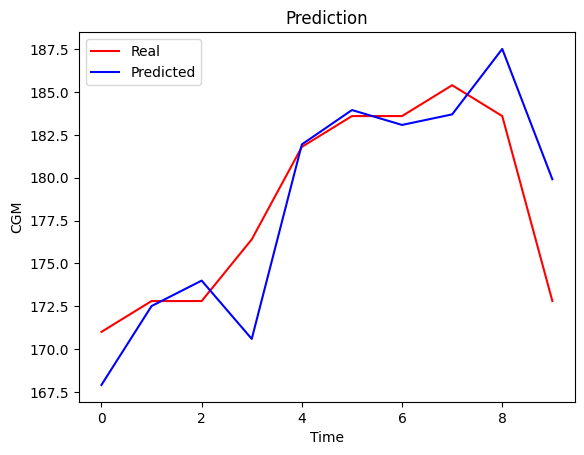

In [24]:
import matplotlib.pyplot as plt
plt.plot(testY[:10], color = 'red', label = 'Real')
plt.plot(y_pred[:10], color = 'blue', label = 'Predicted')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.legend()
plt.show()